In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.core.groupby.generic import DataFrameGroupBy
import prince
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import cluster, mean_squared_error
import itertools
from sklearn import metrics
import seaborn as sns
from matplotlib import pyplot
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler
import datetime as dt
from datetime import date, datetime
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC,SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score

In [2]:
data = pd.read_csv("train.csv")

<AxesSubplot:xlabel='Resource Allocation', ylabel='count'>

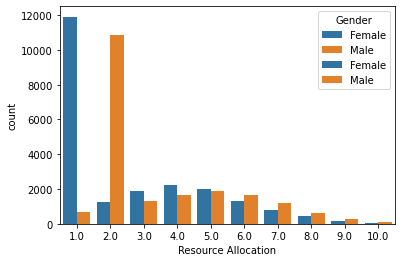

In [3]:
#Male Vs. Female Employees
sns.countplot(x='Gender', hue='Gender', data=data)
sns.countplot(x='Resource Allocation', hue='Gender', data=data)

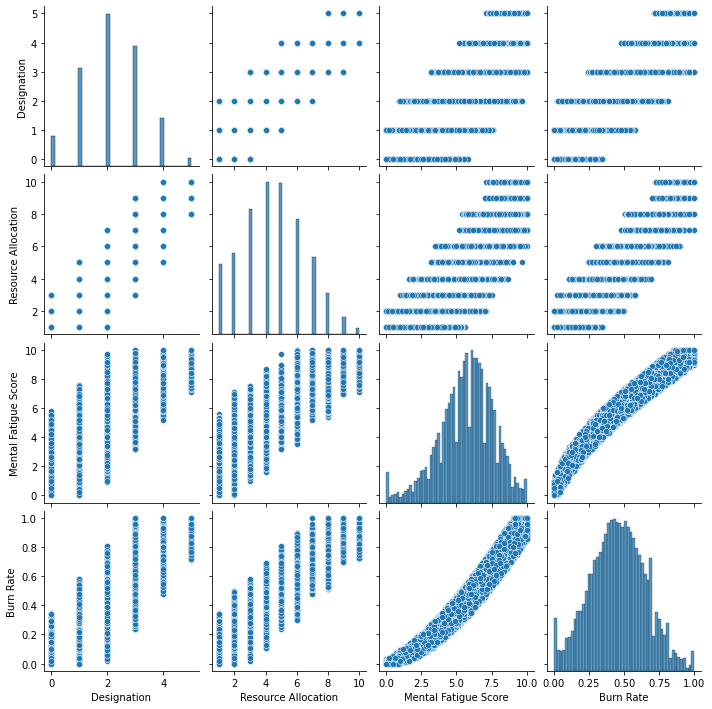

In [4]:
# Scatter plot to understand relationship between variables
sns_plot = sns.pairplot(data)

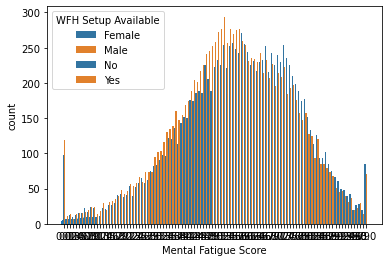

In [5]:
sns.countplot(x='Mental Fatigue Score', hue='Gender', data=data)
sns.countplot(x='Mental Fatigue Score', hue='WFH Setup Available', data=data)
plt.scatter(data['Mental Fatigue Score'], data['Designation'])
plt.show()

In [6]:
print(data['Designation'].value_counts(), end="\n\n")
print(data['Company Type'].value_counts(), end="\n\n")
print(data['WFH Setup Available'].value_counts(), end="\n\n")

2.0    7588
3.0    5985
1.0    4881
4.0    2391
0.0    1507
5.0     398
Name: Designation, dtype: int64

Service    14833
Product     7917
Name: Company Type, dtype: int64

Yes    12290
No     10460
Name: WFH Setup Available, dtype: int64



In [7]:
data.corr()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
Designation,1.000000,0.878459,0.690983,0.737556
Resource Allocation,0.878459,1.000000,0.799662,0.856278
Mental Fatigue Score,0.690983,0.799662,1.000000,0.944546
Burn Rate,0.737556,0.856278,0.944546,1.000000


In [8]:
# #Step2: Data pre processing 

In [9]:
# # a. Check data for any missing values
print(data.isna().sum())
print(data.columns)

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64
Index(['Employee ID', 'Date of Joining', 'Gender', 'Company Type',
       'WFH Setup Available', 'Designation', 'Resource Allocation',
       'Mental Fatigue Score', 'Burn Rate'],
      dtype='object')


In [10]:
# Following column have null values: 
    # Resource Allocation     1381
    # Mental Fatigue Score    2117
    # Burn Rate               1124

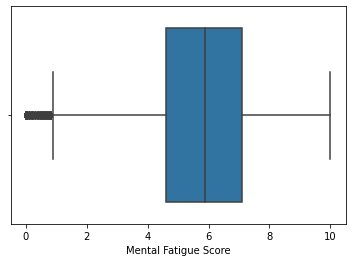

In [11]:
# check for MFS
sns.boxplot(x = data['Mental Fatigue Score'])
plt.show()

# drop the outlier values 
outlier1 = data[data['Mental Fatigue Score'] < 0.9].index
data = data.drop(outlier1)

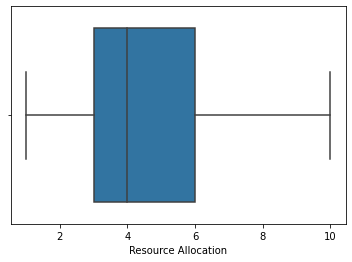

(22403, 9)


In [12]:
# Check for RA
sns.boxplot(x = data['Resource Allocation'])
plt.show()
print(data.shape)


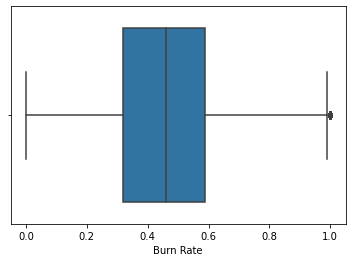

In [13]:
# Check for BR
sns.boxplot(x = data['Burn Rate'])
plt.show()

Text(0.5, 0, 'RA')

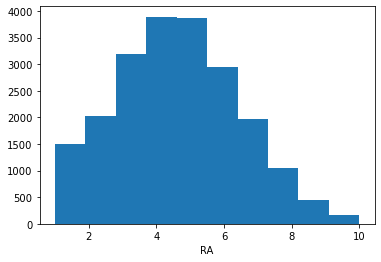

In [14]:
# Check for data distribution to see if data can be imputed instead of dropping 
plt.figure()
plt.hist(data['Resource Allocation'])
plt.xlabel('RA')

Text(0.5, 0, 'MFS')

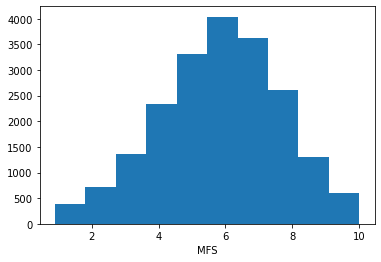

In [15]:
plt.figure()
plt.hist(data['Mental Fatigue Score'])
plt.xlabel('MFS')


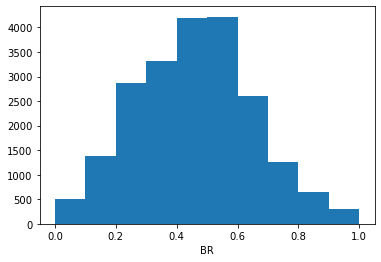

In [16]:
plt.figure()
plt.hist(data['Burn Rate'])
plt.xlabel('BR')
plt.show()

In [17]:
# Since the data is normally distributed, instead of removing we can impute values with mean
data['Resource Allocation'] = data['Resource Allocation'].fillna(value = data['Resource Allocation'].mean())
data['Mental Fatigue Score'] = data['Mental Fatigue Score'].fillna(value = data['Mental Fatigue Score'].mean())
data['Burn Rate'] = data['Burn Rate'].fillna(value = data['Burn Rate'].mean())

In [18]:
data = data.drop('Employee ID', axis= 1)
data = data.dropna(axis = 0)
data.reset_index(inplace= True)

In [19]:
def month_difference(date_1, date_2):
    return ((date_1.year - date_2.year)*12) + (date_1.month - date_2.month)

total_months_worked = []
for each in data.index:
    total_months_worked.append(month_difference(datetime(2021, 12, 1) ,date.fromisoformat(data.loc[each, 'Date of Joining'])))

data['Total Months Worked'] = total_months_worked

In [20]:
data = data.drop(['index','Date of Joining'],axis=1)

In [21]:
data1 = data.copy()
# Cluster Analysis 
categorical = ['Gender', 'Company Type',
       'WFH Setup Available', 'Designation']
for column in categorical: #numerically encode all categorical variables 
    data1[column] = LabelEncoder().fit_transform(data1[column])
data1

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Total Months Worked
0,0,1,0,2,3.000000,3.800000,0.16,159
1,1,1,1,1,2.000000,5.000000,0.36,157
2,0,0,1,2,4.533698,5.800000,0.49,165
3,1,1,1,1,1.000000,2.600000,0.20,157
4,0,1,0,3,7.000000,6.900000,0.52,161
...,...,...,...,...,...,...,...,...
22398,0,1,0,1,3.000000,5.821926,0.41,156
22399,0,0,1,3,6.000000,6.700000,0.59,167
22400,1,1,1,3,7.000000,5.821926,0.72,157
22401,0,1,0,2,5.000000,5.900000,0.52,167


In [22]:
scaled_num_data = StandardScaler().fit_transform(data1)

In [23]:
min_bic = None
best_k = 0
for k in range(2,11):
    gm = GaussianMixture(n_components=k, n_init=10, init_params='kmeans', 
                        random_state=42).fit(scaled_num_data)
    bic = gm.bic(scaled_num_data)
    labels = gm.predict(scaled_num_data)
    if min_bic is None or bic < min_bic:
        min_bic = bic
        best_k = k
    print(k)
    print(bic)
    print(np.unique(labels))
print('min bic is ', min_bic)
print('Best k is ', best_k)

2
121133.09535501694
[0 1]
3
119425.08032838478
[0 1 2]
4
-180997.6635624474
[0 1 2 3]
5
-186933.88652908462
[0 1 2 3 4]
6
-182148.15268989105
[0 1 2 3 4 5]
7
-376410.07791889145
[0 1 2 3 4 5 6]
8
-407867.65585834795
[0 1 2 3 4 5 6 7]
9
-440462.75056957046
[0 1 2 3 4 5 6 7 8]
10
-379188.01270500774
[0 1 2 3 4 5 6 7 8 9]
min bic is  -440462.75056957046
Best k is  9


In [24]:
gm = GaussianMixture(n_components = best_k, n_init = 10, init_params='kmeans', random_state = 42).fit(scaled_num_data)
cluster = (gm.predict(scaled_num_data))

In [26]:
# Creating a new column called overworked for threshold value of Burn Rate = 0.7, so that we can understand if an employee is Overworked or not.

data_Overworked = []
for i in list(data['Burn Rate']):
    if i <=0.7:
        data_Overworked.append(0) # Overworked = No
    else:
        data_Overworked.append(1) # Overworked = Yes

In [27]:
data['Overworked'] = data_Overworked

In [29]:
data['Overworked'].value_counts()

0    20205
1     2198
Name: Overworked, dtype: int64

In [ ]:
"""

Here we could see that the ratio of the classes we created is roughly 9:1 (No:Yes), which tells us that there is imbalance of
classes and result in our model being biased towards the majority class. Thus we decided to use some sampling techniques to try
and make our dataset balanced.

We had 3 possible methods to tackle this issue:
1) Upsampling of the minority class which would add a very high number of arbitrary data, introducing bias in the dataset.
2) Downsampling of the majority class which would significantly decrease the variance of the majority class in the dataset. 
3) Upsampling and downsampling the data together.

Taking into consideration the bias - variance tradeoff, we decided to go ahead with the 3rd method for handling the imbalance 
in the data and used the SMOTETOMEK function from the imlearn library for this purpose.

"""



In [30]:
# Using One hot encoding for encoding the categorical variables.

data = pd.get_dummies(data, columns = ['Gender', 'Company Type', 'WFH Setup Available', 'Designation'], drop_first=True)
## Default values
# 'Gender' default - Female
# 'Company Type' default - Product
# 'WFH Setup Available' default - No
# 'Designation' default - 0

In [31]:
# Separating feature and response for Classification
X = data.drop(['Burn Rate', 'Overworked'],axis=1)
y = data['Overworked']

In [32]:
smt = SMOTETomek(random_state=42) # instantiating the SMOTETomek object
X_res,y_res=smt.fit_resample(X,y) # resampling the train set

In [33]:
y_res.value_counts()

1    20062
0    20062
Name: Overworked, dtype: int64

In [34]:
# Train test split of the resampled data for classification models
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2, random_state = 42)

In [35]:
# building the pipeline for Support Vector Classifer 

svc_clf = Pipeline([
    ('scalar', StandardScaler()),
    ('svc', SVC())
])

parameters = { 'svc__kernel' : ['rbf','sigmoid'],
             'svc__C' : [ 0.1, 1, 10, 100],
             'svc__gamma': [0.1,0.5]} 

grid_svc = GridSearchCV(svc_clf,parameters,cv=3, n_jobs=-1)
grid_svc.fit(X_train,y_train)

In [37]:
# building the pipeline for Decision Tree Classifer 

DT_clf = Pipeline([
    ('scalar', StandardScaler()),    
    ('DT', DecisionTreeClassifier())
])

parameters = { 'DT__max_leaf_nodes' : [100,200,300,400,500],
             'DT__min_samples_leaf' : [ 2,5,10,20],
             'DT__splitter': ['best','random']} 

grid_DT = GridSearchCV(DT_clf,parameters,cv=3, n_jobs=-1)
grid_DT.fit(X_train,y_train)

In [39]:
# building the pipeline for Logistic Regression binary classification 

LR_clf = Pipeline([
    ('scalar', StandardScaler()),    
    ('lr', LogisticRegression(random_state=42))
])

parameters = { 'lr__max_iter' : [1000,10000,50000,100000],
             'lr__penalty' : ['l1','l2'],
             'lr__solver': ['liblinear','saga']} 

grid_LR = GridSearchCV(LR_clf,parameters,cv=3, n_jobs=-1)
grid_LR.fit(X_train,y_train)

In [41]:
# building the pipeline for Random Forest Classifer 

RF_clf = Pipeline([
    ('scalar', StandardScaler()),    
    ('RF', RandomForestClassifier(random_state=42))
])

parameters = { 'RF__n_estimators' : [100,500,1000],
             'RF__min_samples_split' : [5,10,15]} 

grid_RF = GridSearchCV(RF_clf,parameters,cv=3, n_jobs=-1)
grid_RF.fit(X_train,y_train)

In [43]:
# building the pipeline for Gradient Boost Classifer 

GB_clf = Pipeline([
    ('scalar', StandardScaler()),    
    ('GB', GradientBoostingClassifier(random_state=42))
])

parameters = { 'GB__n_estimators' : [100,500,1000],
             'GB__min_samples_split' : [5,10,15],
             'GB__loss' : ['deviance','exponential']} 

grid_GB = GridSearchCV(GB_clf,parameters,cv=3, n_jobs=-1)
grid_GB.fit(X_train,y_train)

In [46]:
clf_models = [grid_GB, grid_RF, grid_LR, grid_DT, grid_svc]
auc, acc, precision, recall = [],[],[],[] # creating empty list to store the evalution metrics of model

for model in clf_models:
    precision.append(round(precision_score(model.predict(X_test), y_test),2))
    auc.append(round(roc_auc_score(model.predict(X_test), y_test),2))
    acc.append(round(accuracy_score(model.predict(X_test), y_test),2))
    recall.append(round(recall_score(model.predict(X_test), y_test),2))

In [47]:
clf_models = ['Gradient Boost', 'Random Forest', 'Logistic Regression', 'Decision Tree', 'SVC']

In [48]:
# creating individual dataframes for each list
results = pd.DataFrame(clf_models) 
results1 = pd.DataFrame(acc)
results2 = pd.DataFrame(auc)
results3 = pd.DataFrame(precision)
results4 = pd.DataFrame(recall)

In [49]:
results['Accuracy']=results1[0] # adding the Accuracy scores in the results dataframe
results['AUC']=results2[0] # adding the AUC in the results dataframe
results['Precision']=results3[0] # adding the Precision in the results dataframe
results['Recall']=results4[0] # adding the Recall in the results dataframe
results = results.rename(columns={0: 'Model'}) # renaming the column
results

,Model,Accuracy,AUC,Precision,Recall
0,Gradient Boost,0.97,0.97,0.97,0.97
1,Random Forest,0.97,0.97,0.98,0.96
2,Logistic Regression,0.92,0.92,0.93,0.91
3,Decision Tree,0.97,0.97,0.97,0.96
4,SVC,0.95,0.95,0.97,0.94
